# Peri-Event time histogram around sharp-waves ripples


This tutorial shows how to align spikes times to a particular events and plot rasters.

See the [documentation](https://peyrachelab.github.io/pynapple/) of pynapple to see how to install the package. 

The example data can be found [here](https://www.dropbox.com/s/1kc0ulz7yudd9ru/A2929-200711.tar.gz?dl=1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynapple as nap
import pandas as pd
import seaborn as sns
import warnings

sns.set_theme(style="darkgrid")

Let's load the data

In [2]:
DATA_DIRECTORY = '/home/guillaume/pynapple/data/A2929-200711'

data = nap.load_session(DATA_DIRECTORY, 'neurosuite')

spikes = data.spikes

print(spikes)

  Index    Freq. (Hz)    group  location
-------  ------------  -------  ----------
      0          7.3         0  adn
      1          5.73        0  adn
      2          8.12        0  adn
      3          6.68        0  adn
      4         10.77        0  adn
      5         11           0  adn
      6         16.52        0  adn
      7          2.2         1  ca1
      8          2.02        1  ca1
      9          1.07        1  ca1
     10          3.92        1  ca1
     11          3.31        1  ca1
     12          1.09        1  ca1
     13          1.28        1  ca1
     14          1.32        1  ca1


The events are sleep ripples detected in CA1. (See this [notebook](https://github.com/PeyracheLab/pynacollada/blob/main/pynacollada/eeg_processing/Tutorial_ripple_detection.ipynb) for detecting the ripples in this dataset).

In [3]:
tsd = data.load_nwb_timeseries('sleep_ripples')
print(tsd)

Time (s)
0.7712      7.914239
0.9232      4.948673
1.0744      5.199699
1.6832      6.297220
1.8112      2.984884
              ...   
595.0304    1.449906
597.2712    6.576567
597.9744    1.223363
598.4904    3.645479
599.6944    8.550664
Length: 594, dtype: float64


## Peri-Event Time Histogram

Some neurons were recorded in CA1 and some neurons in ADN in the thalamus. Let's check the activity of a CA1 neurons around the times of the hippocampal ripples. We can use the function compute_peristimulus to do a raster plot and compute a peri-event time histogram of one neuron between -400 ms before the ripple time and 600 ms after.

In [4]:
warnings.filterwarnings("ignore")

peth14 = nap.compute_perievent(spikes[14], tsd, minmax=(-400, 600), time_unit='ms')

print(peth14[list(range(5))]) # showing only the first five events

  Index    Freq. (Hz)    ref_times
-------  ------------  -----------
      0             7       0.7712
      1             7       0.9232
      2             7       1.0744
      3           nan       1.6832
      4             3       1.8112


By default, _compute_peristimulus_ add the reference times of as a meta info for each element of the TsGroup. Each element contains the spikes within the window (-300, 600) centered around the ripple time.

In [5]:
print(peth14[0])

Time (s)
-0.02035   NaN
-0.00655   NaN
 0.00230   NaN
 0.01480   NaN
 0.05145   NaN
 0.14715   NaN
 0.15375   NaN
dtype: float64


Note that the time support is the window.

In [6]:
print(peth14.time_support)
print(peth14[14].time_support)

   start  end
0   -0.4  0.6
   start  end
0   -0.4  0.6


We can add another metainfo to the _peth14_ object such as ripples peak power to select ripples.

In [7]:
peth14.set_info(rip_power = tsd.values)
print(peth14[list(range(5))])

  Index    Freq. (Hz)    ref_times    rip_power
-------  ------------  -----------  -----------
      0             7       0.7712      7.91424
      1             7       0.9232      4.94867
      2             7       1.0744      5.1997
      3           nan       1.6832      6.29722
      4             3       1.8112      2.98488


Let's select events with rip_power above 2

In [8]:
warnings.filterwarnings("ignore")
peth14_2 = peth14.getby_threshold('rip_power', 2)
peth14_2

  Index    Freq. (Hz)    ref_times    rip_power
-------  ------------  -----------  -----------
      0             7       0.7712      7.91424
      1             7       0.9232      4.94867
      2             7       1.0744      5.1997
      3           nan       1.6832      6.29722
      4             3       1.8112      2.98488
      5             3       2.348       3.53926
      6             1       5.3736      5.5326
      7           nan       6.4016      5.65958
      8           nan       8.66        4.21838
      9           nan       8.8088      2.21569
     11           nan       9.4672      2.93781
     12           nan       9.828       2.99653
     13             1      14.1408      2.99166
     16             5      15.2336      7.1559
     17             5      15.3808      8.50468
     18             3      15.8408      2.49151
     20             5      17.752       6.47327
     21             5      17.8848      2.87832
     22             3      20.0048      3.0

Since all elements are aligned within the same time window, it is easy to compute a perievent time histogram by calling the _count_ function. Here the spikes are binned around the ripple times with 10 ms bins then averaged for all ripples.

In [9]:
rip_ct_14 = peth14_2.count(0.01).as_units('s').mean(1)

print(rip_ct_14)

Time (s)
-0.395    0.030806
-0.385    0.026066
-0.375    0.030806
-0.365    0.016588
-0.355    0.021327
            ...   
 0.555    0.037915
 0.565    0.028436
 0.575    0.042654
 0.585    0.033175
 0.595    0.045024
Length: 100, dtype: float64


## Raster plot

Let's plot everything

By default, the object peth_14_2 contains only spikes times. It's easy to plot spikes times by associating spikes times with a position with the _fillna_ function of pandas.

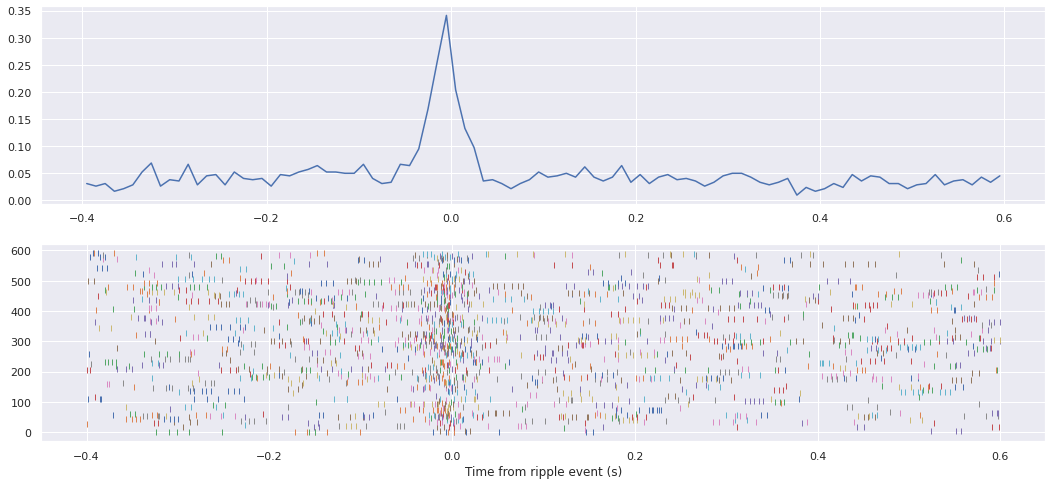

In [10]:
plt.figure(figsize = (18, 8))

plt.subplot(211)
plt.plot(rip_ct_14)
plt.subplot(212)
for event in peth14_2.keys():
    plt.plot(peth14_2[event].as_units('s').fillna(event), '|')
plt.xlabel("Time from ripple event (s)")
plt.show()

Now let's compute the PETH for all CA1 neurons.

In [11]:
warnings.filterwarnings("ignore")
ca1_spikes = spikes.getby_category('location')['ca1']
peth_ca1 = nap.compute_perievent(ca1_spikes, tsd, minmax=500, time_unit='ms')

mean_fr_ca1 = {}
for n in peth_ca1.keys():
    mean_fr_ca1[n] = peth_ca1[n].count(0.01, time_units = 's').as_units('s').mean(1)

mean_fr_ca1 = pd.DataFrame.from_dict(mean_fr_ca1)

print(mean_fr_ca1)

                7         8         9         10        11        12  \
Time (s)                                                               
-0.495    0.040404  0.013468  0.025253  0.028620  0.026936  0.003367   
-0.485    0.038721  0.018519  0.016835  0.042088  0.016835  0.003367   
-0.475    0.031987  0.016835  0.028620  0.040404  0.033670  0.003367   
-0.465    0.042088  0.005051  0.025253  0.047138  0.030303  0.008418   
-0.455    0.037037  0.013468  0.037037  0.052189  0.035354  0.005051   
...            ...       ...       ...       ...       ...       ...   
 0.455    0.043771  0.008418  0.023569  0.033670  0.021886  0.005051   
 0.465    0.042088  0.016835  0.020202  0.033670  0.015152  0.003367   
 0.475    0.047138  0.031987  0.021886  0.028620  0.015152  0.006734   
 0.485    0.040404  0.018519  0.025253  0.040404  0.028620  0.006734   
 0.495    0.035354  0.016835  0.025253  0.047138  0.013468  0.003367   

                13        14  
Time (s)                      
-

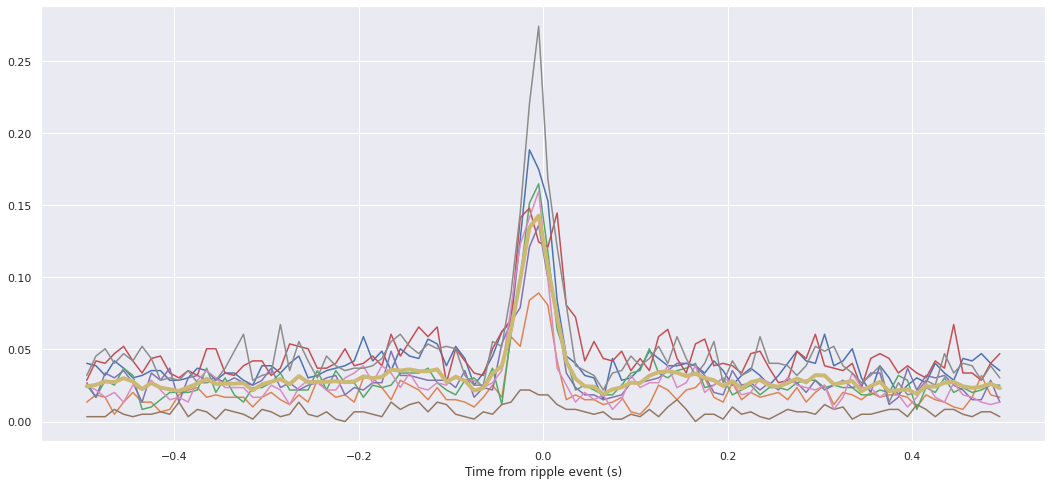

In [12]:
plt.figure(figsize = (18, 8))

plt.subplot(111)
plt.plot(mean_fr_ca1)
plt.plot(mean_fr_ca1.mean(1), linewidth = 4)
plt.xlabel("Time from ripple event (s)")
plt.show()